<a href="https://colab.research.google.com/github/yhw4343/tmp/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-jpzfu2tf
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-jpzfu2tf
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=113112 sha256=e7c01c7833815e14eea7e63c63541065fd1e859d0d3c83a18e9a6f18e62103ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vfh2eeh/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 M

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uhyunwoo","key":"28b86a1ce9618b2df57d2f9e59a38a7f"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d waynewhying/unifesp-xray-body-224-224

 86% 45.0M/52.1M [00:00<00:00, 91.0MB/s]
100% 52.1M/52.1M [00:00<00:00, 97.1MB/s]


In [5]:
! unzip -qq unifesp-xray-body-224-224.zip

In [6]:
import os

In [7]:
os.listdir()

['.config',
 'unifesp-xray-body-224-224.zip',
 'train',
 'kaggle.json',
 'test',
 'sample_data']

In [10]:
! pip uninstall opencv-contrib-python

! pip install opencv-contrib-python

#cv2 오류시 언인스톨 후 인스톨

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/config-3.py
    /usr/local/lib/python3.7/dist-packages/cv2/config.py
    /usr/local/lib/python3.7/dist-packages/cv2/cv2.abi3.so
    /usr/local/lib/python3.7/dist-packages/cv2/gapi/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py2.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py3.py
    /usr/local/lib/python3.7/dist-packages/cv2/mat_wrapper/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/version.py
    /usr/local/lib/python3.7/dist-packages/cv2/utils/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/version.py
Procee

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import albumentations as album
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import StratifiedKFold

In [16]:
N_SPLITS = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 200
PATIENCE = 8
MAX_LR = 1e-5
MIN_LR = 1e-6

In [17]:
class_names = np.array(["Abdomen", "Ankle", "Cervical Spine", "Chest", 
                        "Clavicles", "Elbow", "Feet", "Finger",
                        "Forearm", "Hand", "Hip", "Knee",  
                        "Lower Leg", "Lumbar Spine", "Others", "Pelvis", 
                        "Shoulder", "Sinus", "Skull", "Thigh", 
                        "Thoracic Spine", "Wrist"])

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
dpath = '/content/drive/MyDrive/'

In [20]:
df = pd.read_csv(dpath+"train.csv")
df.head()

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3


In [21]:
images_path = "/content/train/"
temp_SOPInstanceUID = []
for i in df.SOPInstanceUID:
    temp_SOPInstanceUID.append(images_path + i + ".png")
df.SOPInstanceUID = temp_SOPInstanceUID

In [22]:
num_classes = 22
targets = np.zeros((len(df.Target), num_classes), dtype=int)
for i, t in enumerate(df.Target):
    target = t.strip().split()
    for j in target:
        targets[i, int(j)] = 1

In [23]:
df2 = pd.DataFrame(targets, columns=class_names)
df = pd.concat([df, df2], axis=1) 
df.head()

,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,/content/train/1.2.826.0.1.3680043.8.498.10025...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/train/1.2.826.0.1.3680043.8.498.10036...,15,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,/content/train/1.2.826.0.1.3680043.8.498.10038...,12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,/content/train/1.2.826.0.1.3680043.8.498.10050...,14,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,/content/train/1.2.826.0.1.3680043.8.498.10053...,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


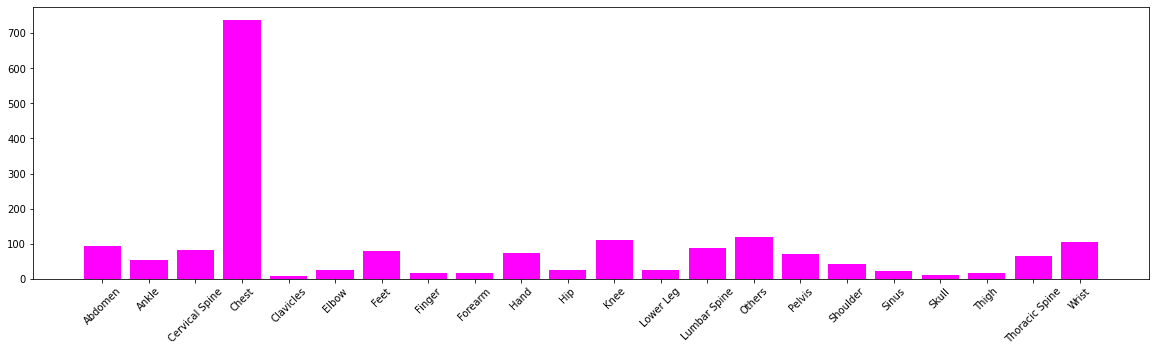

In [24]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(22), targets.sum(axis=0), color='magenta')
plt.xticks(ticks=np.arange(22), labels=class_names, rotation=45)
plt.show()

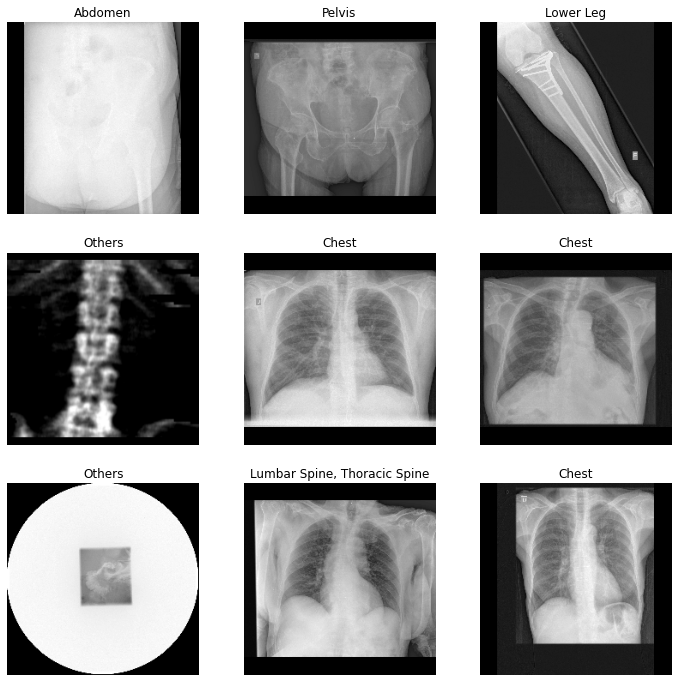

In [25]:
plt.figure(figsize=(12, 12))
for i in range(9):
    # image
    ax = plt.subplot(3, 3, i+1)
    filename = df.iloc[i].SOPInstanceUID
    img = imread(filename)
    plt.imshow(img, cmap='gray')
    # titles
    labels = df.iloc[i].Target.strip().split()
    if len(labels) == 1:
        plt.title(class_names[int(labels[0])])
    else:
        titles = []
        for label in labels:
            titles.append(class_names[int(label)])
        plt.title(", ".join(titles))
    plt.axis("off")
plt.show()

In [26]:
df_test = pd.read_csv(dpath+"sample_submission.csv")
df_test.head()

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [27]:
images_path = "../content/test/"
temp_SOPInstanceUID = []
for i in df_test.SOPInstanceUID:
    temp_SOPInstanceUID.append(images_path + i + ".png")
df_test.SOPInstanceUID = temp_SOPInstanceUID

In [28]:
df_test.head()

,SOPInstanceUID,Target
0,../content/test/1.2.826.0.1.3680043.8.498.1000...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,../content/test/1.2.826.0.1.3680043.8.498.1003...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [29]:
X_test = df_test.SOPInstanceUID.to_numpy()

In [30]:
X = df.SOPInstanceUID.to_numpy()
y = df.iloc[:, 2:].to_numpy()

In [31]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for train_index, valid_index in skf.split(X, np.argmax(y, axis=1)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

print(f"train size: {y_train.shape[0]}")
print(f"valid size: {y_valid.shape[0]}")

train size: 1159
valid size: 579


In [32]:
class DataAugmentation:
    def __init__(self):
        self.transforms = album.Compose([
            album.HorizontalFlip(p=0.5),
            album.ShiftScaleRotate(shift_limit=0.15, 
                                   scale_limit=0.2, 
                                   rotate_limit=25, 
                                   border_mode=cv2.BORDER_CONSTANT, p=0.75),
            album.OneOf([
                album.RandomBrightnessContrast(brightness_limit=0.2, 
                                               contrast_limit=0.2, p=0.5),
                album.RandomGamma(gamma_limit=(70, 130), p=0.5),
                ], p=0.5),
            album.OneOf([
                album.Blur(p=0.1),
                album.GaussianBlur(p=0.1),
                album.MotionBlur(p=0.1),
                ], p=0.1),
            album.OneOf([
                album.GaussNoise(p=0.1),
                album.GridDropout(ratio=0.5, p=0.2),
                album.CoarseDropout(max_holes=16, max_height=16, max_width=16,
                                    min_holes= 8, min_height= 8, min_width= 8, p=0.2)
                ], p=0.5),
            ])

    def aug_fn(self, image):
        data = {"image":image}
        aug_data = self.transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def augment_iamge(self, img, label):
        aug_img = tf.numpy_function(func=self.aug_fn, inp=[img], Tout=tf.float32)
        return aug_img, label

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

In [34]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)
    return img, label

def process_test_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)
    return img

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test))

In [36]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_test_path, num_parallel_calls=AUTOTUNE)

In [37]:
aug_train = DataAugmentation()
train_ds = train_ds.map(aug_train.augment_iamge, num_parallel_calls=AUTOTUNE)

In [38]:
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [39]:
image_batch, label_batch = next(iter(train_ds))

In [40]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [93]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def get_model(input_shape, output_shape):
    base_model = tf.keras.applications.VGG16(input_shape=(input_shape[0],input_shape[1],3),
                                                                   include_top=False)
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.tile(inputs, (1, 1, 1, 3))
    # Transfer Learning
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # Dense
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    outputs = tf.keras.layers.Dense(output_shape, activation="sigmoid", dtype='float32')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [94]:
model = get_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), output_shape=num_classes)

In [95]:
steps_per_epoch = len(y_train)//BATCH_SIZE
validation_steps = len(y_valid)//BATCH_SIZE

In [96]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.1,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [97]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [98]:
tf.config.run_functions_eagerly(True)

In [99]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1)

Epoch 1/200
72/72 [==============================] - 15s 202ms/step - loss: 3.4942 - binary_accuracy: 0.4838 - val_loss: 1.9003 - val_binary_accuracy: 0.5281
Epoch 2/200
72/72 [==============================] - 14s 200ms/step - loss: 2.9928 - binary_accuracy: 0.4940 - val_loss: 1.4942 - val_binary_accuracy: 0.5570
Epoch 3/200
72/72 [==============================] - 13s 186ms/step - loss: 2.1607 - binary_accuracy: 0.5151 - val_loss: 1.0725 - val_binary_accuracy: 0.5973
Epoch 4/200
72/72 [==============================] - 13s 187ms/step - loss: 1.4525 - binary_accuracy: 0.5544 - val_loss: 0.7972 - val_binary_accuracy: 0.6334
Epoch 5/200
72/72 [==============================] - 14s 188ms/step - loss: 1.0420 - binary_accuracy: 0.5882 - val_loss: 0.6347 - val_binary_accuracy: 0.6712
Epoch 6/200
72/72 [==============================] - 14s 202ms/step - loss: 0.8095 - binary_accuracy: 0.6250 - val_loss: 0.5449 - val_binary_accuracy: 0.7187
Epoch 7/200
72/72 [==============================] -

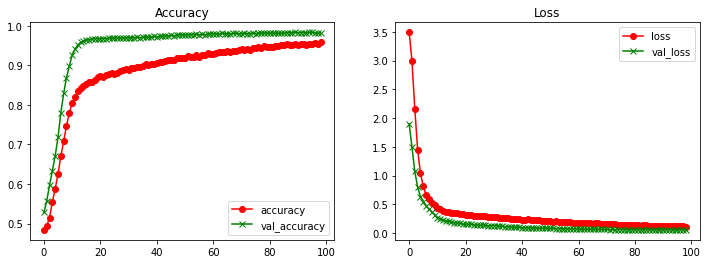

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['binary_accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_binary_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [101]:
pred = model.predict(test_ds, verbose=1)

temp = []
for i in pred:
    ans = np.where(i>0.9)[0]
    if ans.shape[0] == 0:
        temp.append(str(np.argmax(i)))
    else:
        temp.append(" ".join(ans.astype(str)))

df_test = pd.read_csv(dpath+"sample_submission.csv")
df_test.Target = temp

df_test.to_csv("./submission.csv", index=False)

47/47 [==============================] - 2s 45ms/step


In [102]:
df_test

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,9
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,3
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,21
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,3
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,3
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746...,3
739,1.2.826.0.1.3680043.8.498.99120415799121180043...,3
740,1.2.826.0.1.3680043.8.498.99132008951330408682...,3
741,1.2.826.0.1.3680043.8.498.99611256581875030709...,21
